<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/rnncrf_pitch_spelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade pytorch-crf

In [1]:
# from google.colab import files

import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F
#from torchcrf import CRF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
import pickle

from sklearn.metrics import accuracy_score

import time

import kmeans1d
import jenkspy

from collections import defaultdict, Counter
# import optuna

import importlib

# Pitch Spelling and ks Prediction

Dataset: different authors from ASAP collection
Challenges:
- extremely long sequences
- small dataset

## Import ASAP dataset

In [2]:
# !git clone https://github.com/fosfrancesco/pitch-spelling.git

basepath = "./" #to change if running locally or on colab
# load the asap datasets with ks
with open(Path('../asapks.pkl'), 'rb') as fid:
     full_dict_dataset = pickle.load( fid)

######## Note for Nicolas: I called it "dict_dataset", but it is a list of dictionaries
paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))


222 different pieces
Average number of notes:  2410.253424657534


## Chose the convenient data augmentation
For each chromatic interval, take only the diatonic transposition that produce the smallest number of accidentals (or the original if present).

Then remove the pieces with ks that have more than 7 sharps or 7 flats.

In [3]:
from pitches import keep_best_transpositions
from utils import root_folder
                                                    
dict_dataset = keep_best_transpositions(full_dict_dataset)
# #test if it worked
# for i,e in enumerate(dict_dataset):
#     print(e["original_path"], e["transposed_of"], e["key_signatures"])
#     print(e["pitches"][:10])
#     print(e["midi_number"][:10])
#     if i == 100:
#         break

composer_per_piece = [root_folder(p) for p in paths]
c = Counter(composer_per_piece)

print(f"Dataset has {len(dict_dataset)} pieces.")
print(f"By composer: {', '.join(map(lambda item: item[0] + ': ' + str(item[1]), c.items()))}")

No options for Liszt/Sonata/xml_score.musicxml . Chromatic:  4
No options for Liszt/Sonata/xml_score.musicxml . Chromatic:  6
No options for Liszt/Sonata/xml_score.musicxml . Chromatic:  11
No options for Chopin/Etudes_op_25/10/xml_score.musicxml . Chromatic:  4
No options for Chopin/Etudes_op_25/10/xml_score.musicxml . Chromatic:  9
No options for Scriabin/Sonatas/5/xml_score.musicxml . Chromatic:  1
No options for Scriabin/Sonatas/5/xml_score.musicxml . Chromatic:  6
No options for Scriabin/Sonatas/5/xml_score.musicxml . Chromatic:  11
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  1
No options for Liszt/Transcendental_Etudes/11/xml_score.musicxml . Chromatic:  6
No options for Liszt/Mephisto_Waltz/xml_score.musicxml . Chromatic:  11
No options for Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml . Chromatic:  1
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  4
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  

In [4]:
# remove pieces from asap that are in Musedata
print(len(paths), "initial pieces")
paths = [p for p in paths if p!= "Bach/Prelude/bwv_865/xml_score.musicxml"]

#remove mozart Fantasie because of incoherent key signature
paths = [p for p in paths if p!= 'Mozart/Fantasie_475/xml_score.musicxml']

print(len(paths), "pieces after removing overlapping with musedata and Mozart Fantasie")

222 initial pieces
220 pieces after removing overlapping with musedata and Mozart Fantasie


Train and validation lenghts:  163 29
Remaining composers: ['Schumann', 'Beethoven', 'Bach', 'Haydn', 'Chopin', 'Schubert', 'Mozart', 'Rachmaninoff']


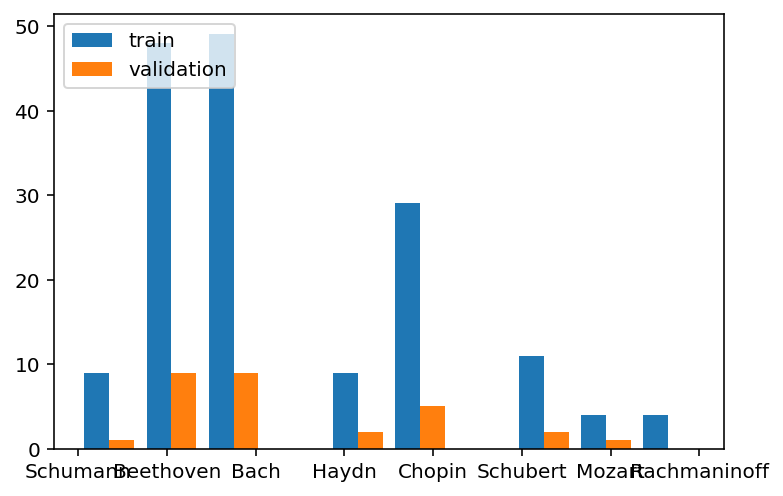

In [5]:
# Temporary remove composer with only one piece, because they create problems with sklearn stratify
one_piece_composers = ['Balakirev','Prokofiev','Brahms','Glinka', 'Debussy', 'Ravel', 'Scriabin','Liszt']
paths = [p for p in paths if root_folder(p) not in one_piece_composers]

# Divide train and validation set
path_train, path_validation = sklearn.model_selection.train_test_split(paths, test_size=0.15, stratify=[root_folder(p) for p in paths ])
print("Train and validation lenghts: ",len(path_train),len(path_validation))

#need to find a better way to visualize this
composers = list(set([root_folder(p) for p in paths ]))
print(f"Remaining composers: {composers}")

train_composer = [composers.index(root_folder(p)) for p in path_train]
val_composer = [composers.index(root_folder(p)) for p in path_validation]

_ = plt.hist([train_composer, val_composer], label=['train', 'validation'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(len(composers))), composers)


## Transform the input into a convenient format for the Model

In [2]:
from pitches import PITCHES
from pitches import KEY_SIGNATURES
from utils import PAD
# Helper functions to feed the correct input into the NN 

N_DURATION_CLASSES = 4

accepted_pitches = [ii for i in PITCHES.values() for ii in i]
pitch_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
ks_to_ix = {k: KEY_SIGNATURES.index(k) for k in KEY_SIGNATURES}
#add PADDING TAD
pitch_to_ix[PAD] = len(accepted_pitches)
ks_to_ix[PAD] = len(KEY_SIGNATURES)

midi_to_ix = {m: m for m in range(12)}
#add PADDING TAD
midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))



# class Pitch2Diatonic():
#     def __call__(self, in_seq):
#         return [p for p in in_seq]

class Pitch2Int():
    def __call__(self, in_seq):
        idxs = [pitch_to_ix[w] for w in in_seq]
        return idxs
    
class Ks2Int():
    def __call__(self, in_seq):
        idxs = [ks_to_ix[w] for w in in_seq]
        return idxs

class Int2Pitch():
    def __call__(self, in_seq):
        return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample,weights = None):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot
    
class DurationOneHotEncoder():
    def __init__(self, pitch_alphabet_len, n_dur_class = 4):
        self.pitch_alphabet_len = pitch_alphabet_len
        self.dur_alphabet_len = n_dur_class
        
    def __call__(self, sample, durs):
        sample = torch.tensor(sample,dtype=torch.long)
        onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
        #compute breaks in duration list
        clusters, centroids = kmeans1d.cluster(durs, N_DURATION_CLASSES)   
        quantized_durations = torch.tensor(clusters,dtype=torch.long)
        onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
        return torch.cat([onehot_pitch,onehot_duration],1)
    
        
class ToTensorFloat():
    def __call__(self, sample, durs = None):
        if type(sample) is torch.Tensor:
            return sample.float()
        else:
            return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
    def __call__(self, sample):
        if type(sample) is torch.Tensor:
            return sample.long()
        else:
            return torch.tensor(sample,dtype=torch.long)
    
class MultInputCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample, durs):
        for t in self.transforms:
            sample = t(sample, durs)
        return sample


### Define the preprocessing pipeline
transform_diat = transforms.Compose([Pitch2Int(),ToTensorLong()])
transform_chrom = MultInputCompose([DurationOneHotEncoder(len(midi_to_ix),N_DURATION_CLASSES),ToTensorFloat()])
transform_key = transforms.Compose([Ks2Int(),ToTensorLong()])


# print(set([ks_to_ix[ks] for piece in dict_dataset for ks in piece["key_signatures"]]))
# print(ks_to_ix[PAD])

In [7]:
# Create the dataset
from datasets import PSDataset

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True, sort = True)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

print(len(train_dataset),len(validation_dataset))


# test if it works
for chrom,diat,ks,seq_len in train_dataset:
    print(chrom.shape)
    print(ks.shape)
    print("Division", diat.shape[0]/65)
#     print(torch.argmax(chrom[0:30],1))
#     # print([diatonic_pitches[p.item()] for p in diat[0:30]])
#     print([accepted_pitches[p.item()] for p in diat[0:30]])
    print([p.item() for p in ks[-20:]])
    print([p for p in chrom[-10:,:]])
    print(seq_len)

1833 29
torch.Size([15506, 17])
torch.Size([15506])
Division 238.55384615384617
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
15506
torch.Size([15506, 17])
torch.Size([15506])
Division 238.55384615384617


torch.Size([6957, 17])
torch.Size([6957])
Division 107.03076923076924
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])]
6957
torch.Size([6957, 17])
torch.Size([6957])
Division 107.03076923

torch.Size([6708, 17])
torch.Size([6708])
Division 103.2
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])]
6708
torch.Size([6708, 17])
torch.Size([6708])
Division 103.2
[6, 6, 6, 6, 6, 6, 

torch.Size([6311, 17])
torch.Size([6311])
Division 97.0923076923077
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])]
6311
torch.Size([6311, 17])
torch.Size([6311])
Division 97.0923076923077
[2, 2, 2, 2, 2, 2

torch.Size([5402, 17])
torch.Size([5402])
Division 83.1076923076923
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])]
5402
torch.Size([5348, 17])
torch.Size([5348])
Division 82.27692307692308
[11, 11, 11, 11,

torch.Size([5154, 17])
torch.Size([5154])
Division 79.29230769230769
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
5154
torch.Size([5154, 17])
torch.Size([5154])
Division 79.29230769230769
[13, 13, 13, 13

torch.Size([5076, 17])
torch.Size([5076])
Division 78.0923076923077
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
5076
torch.Size([5076, 17])
torch.Size([5076])
Division 78.0923076923077
[10, 10, 10, 10, 

[tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
4650
torch.Size([4650, 17])
torch.Size([4650])
Division 71.53846153846153
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tenso

Division 67.98461538461538
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
4419
torch.Size([4419, 17])
torch.Size([4419])
Division 67.98461538461538
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

torch.Size([4254, 17])
torch.Size([4254])
Division 65.44615384615385
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])]
4254
torch.Size([4225, 17])
torch.Size([4225])
Division 65.0
[9, 9, 9

[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
4204
torch.Size([4204, 17])
torch.Size([4204])
Division 64.67692307692307
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tenso

torch.Size([4070, 17])
torch.Size([4070])
Division 62.61538461538461
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])]
4070
torch.Size([4070, 17])
torch.Size([4070])
Division 62.6153846153

torch.Size([3878, 17])
torch.Size([3878])
Division 59.66153846153846
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
3878
torch.Size([3878, 17])
torch.Size([3878])
Division 59.66153846153846
[3, 3, 3, 3, 3,

torch.Size([3792, 17])
torch.Size([3792])
Division 58.33846153846154
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
3792
torch.Size([3792, 17])
torch.Size([3792])
Division 58.33846153846154
[10, 10, 10, 10

torch.Size([3451, 17])
torch.Size([3451])
Division 53.09230769230769
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
3451
torch.Size([3451, 17])
torch.Size([3451])
Division 53.09230769230769
[1, 1, 1, 1, 1,

torch.Size([3338, 17])
torch.Size([3338])
Division 51.353846153846156
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
3338
torch.Size([3338, 17])
torch.Size([3338])
Division 51.353846153846156
[1, 1, 1, 1, 

torch.Size([3185, 17])
torch.Size([3185])
Division 49.0
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])]
3185
torch.Size([3124, 17])
torch.Size([3124])
Division 48.06153846153846
[10, 10,

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
2996
torch.Size([2996, 17])
torch.Size([2996])
Division 46.09230769230769
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,

[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])]
2986
torch.Size([2959, 17])
torch.Size([2959])
Division 45.52307692307692
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tenso

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
2775
torch.Size([2775, 17])
torch.Size([2775])
Division 42.69230769230769
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([0., 0., 0., 0.

[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])]
2692
torch.Size([2692, 17])
torch.Size([2692])
Division 41.41538461538462
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tenso

torch.Size([2584, 17])
torch.Size([2584])
Division 39.753846153846155
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
2584
torch.Size([2584, 17])
torch.Size([2584])
Division 39.753846153846155
[4, 4, 4, 4, 

[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])]
2478
torch.Size([2478, 17])
torch.Size([2478])
Division 38.12307692307692
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tenso

torch.Size([2277, 17])
torch.Size([2277])
Division 35.03076923076923
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
2277
torch.Size([2277, 17])
torch.Size([2277])
Division 35.03076923076923
[4, 4, 4, 4, 4,

torch.Size([2232, 17])
torch.Size([2232])
Division 34.33846153846154
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])]
2232
torch.Size([2232, 17])
torch.Size([2232])
Division 34.3384615384

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])]
2103
torch.Size([2103, 17])
torch.Size([2103])
Division 32.353846153846156
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 0., 0., 0

[tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])]
1960
torch.Size([1829, 17])
torch.Size([1829])
Division 28.138461538461538
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tens

torch.Size([1827, 17])
torch.Size([1827])
Division 28.107692307692307
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
1827
torch.Size([1827, 17])
torch.Size([1827])
Division 28.107692307692307
[1, 1, 1, 1, 

torch.Size([1769, 17])
torch.Size([1769])
Division 27.215384615384615
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
1769
torch.Size([1769, 17])
torch.Size([1769])
Division 27.215384615384615
[2, 2, 2, 2, 

torch.Size([1735, 17])
torch.Size([1735])
Division 26.692307692307693
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])]
1735
torch.Size([1735, 17])
torch.Size([1735])
Division 26.692307692307693
[3, 3, 3, 3, 

[tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
1676
torch.Size([1676, 17])
torch.Size([1676])
Division 25.784615384615385
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

torch.Size([1641, 17])
torch.Size([1641])
Division 25.246153846153845
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
1641
torch.Size([1641, 17])
torch.Size([1641])
Division 25.246153846153845
[3, 3, 3, 3, 

torch.Size([1550, 17])
torch.Size([1550])
Division 23.846153846153847
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])]
1550
torch.Size([1550, 17])
torch.Size([1550])
Division 23.846153846153847
[8, 8, 8, 8, 

torch.Size([1511, 17])
torch.Size([1511])
Division 23.246153846153845
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])]
1511
torch.Size([1511, 17])
torch.Size([1511])
Division 23.246153846

torch.Size([1475, 17])
torch.Size([1475])
Division 22.692307692307693
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
1475
torch.Size([1475, 17])
torch.Size([1475])
Division 22.692307692307693
[12, 12, 12, 

[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
1395
torch.Size([1395, 17])
torch.Size([1395])
Division 21.46153846153846
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,

torch.Size([1334, 17])
torch.Size([1334])
Division 20.523076923076925
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])]
1334
torch.Size([1334, 17])
torch.Size([1334])
Division 20.523076923076925
[4, 4, 4, 4, 

torch.Size([1300, 17])
torch.Size([1300])
Division 20.0
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
1300
torch.Size([1300, 17])
torch.Size([1300])
Division 20.0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

[tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]
1194
torch.Size([1194, 17])
torch.Size([1194])
Division 18.369230769230768
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
1058
torch.Size([1058, 17])
torch.Size([1058])
Division 16.276923076923076
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[t

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
968
torch.Size([968, 17])
torch.Size([968])
Division 14.892307692307693
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor([0., 1., 0., 0., 

torch.Size([932, 17])
torch.Size([932])
Division 14.338461538461539
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
932
torch.Size([932, 17])
torch.Size([932])
Division 14.33846153846153

[tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])]
906
torch.Size([906, 17])
torch.Size([906])
Division 13.938461538461539
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor(

torch.Size([835, 17])
torch.Size([835])
Division 12.846153846153847
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])]
835
torch.Size([835, 17])
torch.Size([835])
Division 12.846153846153847
[11, 11, 11, 11, 1

[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])]
807
torch.Size([804, 17])
torch.Size([804])
Division 12.36923076923077
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
762
torch.Size([762, 17])
torch.Size([762])
Division 11.723076923076922
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 1., 0., 0., 

torch.Size([641, 17])
torch.Size([641])
Division 9.861538461538462
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
641
torch.Size([641, 17])
torch.Size([641])
Division 9.861538461538462


[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])]
576
torch.Size([576, 17])
torch.Size([576])
Division 8.861538461538462
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[tensor([0., 0., 0., 0., 0

In [8]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    (chromatic_seq, diatonic_seq,ks_seq, l) = zip(*batch)
    
    chromatic_seq_pad = pad_sequence(chromatic_seq, padding_value=midi_to_ix[PAD])
    diatonic_seq_pad = pad_sequence(diatonic_seq, padding_value=pitch_to_ix[PAD])
    ks_seq_pad = pad_sequence(ks_seq, padding_value=ks_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    chromatic_seq_pad = chromatic_seq_pad[:,perm_idx,:]
    diatonic_seq_pad = diatonic_seq_pad[:,perm_idx]
    ks_seq_pad = ks_seq_pad[:,perm_idx]

    return chromatic_seq_pad, diatonic_seq_pad,ks_seq_pad, seq_lengths

# data_loader = DataLoader(dataset=validation_dataset,  num_workers =1, batch_size=4, shuffle=True, collate_fn=pad_collate)

# #test if it work
# for batch in data_loader:
#     print(batch[0].shape,batch[1].shape,batch[2].shape)
#     print(batch[0])
#     break

## Model Definition

In [101]:
# TODO: search over the best hyperparameters

In [107]:
n_epochs = 30
HIDDEN_DIM = 96 #as it is implemented now, this is double the hidden_dim
LEARNING_RATE = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

#ks rnn hyperparameter
HIDDEN_DIM2= 48

#attention hyperparameter
NUM_HEAD = 2
NUM_LANDMARKS = 64 #should we make this depending on the seq length for each batch? 


train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,transform_key,True,sort=True, truncate = 80)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat,transform_key, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False,collate_fn=pad_collate)

# model = torch.load("./models/temp/model_temp_epoch30-to_restart.pkl")

from models import RNNTagger
from models import RNNMultiTagger
from models import RNNNystromAttentionTagger
from models import RNNMultNystromAttentionTagger

# model = RNNTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)
# model = RNNNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)
# model = RNNMultNystromAttentionTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS,hidden_dim2=HIDDEN_DIM2,num_head=NUM_HEAD,num_landmarks=NUM_LANDMARKS)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = MOMENTUM,weight_decay=WEIGHT_DECAY)
import train
importlib.reload(train)
history = train.training_loop(model,optimizer,train_dataloader,50,val_dataloader)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

Training on device: cuda
Epoch 1: train loss = 3.3037, train_accuracy_pitch: 0.7260, train_accuracy_ks: 0.3482,val_accuracy_pitch: 0.8941,val_accuracy_ks: 0.3039, time = 9.9923
Epoch 2: train loss = 1.3657, train_accuracy_pitch: 0.9174, train_accuracy_ks: 0.6784,val_accuracy_pitch: 0.9354,val_accuracy_ks: 0.5707, time = 9.8740
Epoch 3: train loss = 0.9550, train_accuracy_pitch: 0.9297, train_accuracy_ks: 0.8012,val_accuracy_pitch: 0.9677,val_accuracy_ks: 0.6548, time = 9.9332
Epoch 4: train loss = 0.7805, train_accuracy_pitch: 0.9326, train_accuracy_ks: 0.8395,val_accuracy_pitch: 0.9633,val_accuracy_ks: 0.6191, time = 9.5232
Epoch 5: train loss = 0.6796, train_accuracy_pitch: 0.9383, train_accuracy_ks: 0.8662,val_accuracy_pitch: 0.9679,val_accuracy_ks: 0.6791, time = 9.7318
Epoch 6: train loss = 0.6317, train_accuracy_pitch: 0.9376, train_accuracy_ks: 0.8735,val_accuracy_pitch: 0.9472,val_accuracy_ks: 0.6414, time = 9.9046
Epoch 7: train loss = 0.6052, train_accuracy_pitch: 0.9424, tra

KeyboardInterrupt: 

In [ ]:
#find the best working model on the accuracy
max_accuracy = np.max(history['val_accuracy_pitch'])
best_epoch = np.argmax(history['val_accuracy_pitch'])
print("Best validation accuracy: ",max_accuracy, "at epoch",best_epoch)

plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy_pitch'])
plt.plot(history['val_accuracy_ks'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy_pitch','validation_accuracy_ks'])

In [ ]:
# torch.save(model, "./models/model_asap_crf200dur.pkl")
# files.download("model_asap_crf300.pkl")

### print attention

## Test on Mdata dataset

In [3]:
model = torch.load("./models/model_RNNks.pkl")
# model = torch.load("./models/temp/model_temp_epoch6.pkl")

In [ ]:
def evaluate(model, dataset_path, device=None):
    # load the dataset
    with open(dataset_path, 'rb') as fid:
        full_mdata_dict_dataset = pickle.load( fid)
            
    # add dummy ks to have the same format as asap
    for e in full_mdata_dict_dataset:
        e["key_signatures"] = np.zeros(len(e["pitches"]))
    mdata_paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

    # # remove the symbphony No.100 from Haydn because of the enharmonic transposition
    # paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

    # print(paths)
    print(len(mdata_paths), "different pieces")
    print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))
    
    mdata_dataset = PSDataset(full_mdata_dict_dataset,mdata_paths, transform_chrom,transform_diat,transform_key,sort=False, augment_dataset=False)
    mdata_dataloader = DataLoader(mdata_dataset,  batch_size=2, shuffle=False, collate_fn=pad_collate)

    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Using device: {device}")

    all_inputs = []
    all_predicted_pitch = []
    all_predicted_ks = []
    all_pitches = []
    all_ks = []
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for seqs, pitches,ks,lens in mdata_dataloader:
            # Move data to device
            seqs = seqs.to(device)

            # Predict the model's output on a batch.
            predicted_pitch,predicted_ks = model.predict(seqs,lens)                   
            # Update the evaluation statistics.
            for i,p in enumerate(predicted_pitch):
                all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
                all_predicted_pitch.append(p)
                all_predicted_ks.append(predicted_ks[i])
                all_pitches.append(pitches[0:int(lens[i]),i])
                all_ks.append(ks[0:int(lens[i]),i])

    # Divide accuracy according to author
    authors = []

    for sequence in all_inputs:
    #     print(sequence)
        author = [e["original_path"].split("\\")[-1][:3] for e in full_mdata_dict_dataset
                if len(e["midi_number"]) == len(sequence) and
                list(e["midi_number"]) ==list(sequence) ]
        assert len(author) == 1
        authors.append(author[0])

    considered_authors = list(set(authors))
    print(considered_authors)

    errors_per_author_pitch = {}
    accuracy_per_author_pitch = {}
    notes_per_author = {}
    for ca in considered_authors:
        ca_predicted_pitch = np.concatenate([all_predicted_pitch[i] for i,a in enumerate(authors) if a == ca])
        ca_predicted_ks = np.concatenate([all_predicted_ks[i] for i,a in enumerate(authors) if a == ca])
        ca_pitches = np.concatenate([all_pitches[i] for i,a in enumerate(authors) if a == ca])
        ca_ks = np.concatenate([all_ks[i] for i,a in enumerate(authors) if a == ca])

        ca_acc_pitch = accuracy_score(ca_predicted_pitch,ca_pitches)
        
        accuracy_per_author_pitch[ca] = float(ca_acc_pitch)
        errors_per_author_pitch[ca] = int(len(ca_pitches) - sum(np.equal(ca_predicted_pitch,ca_pitches)))
        notes_per_author[ca] = len(ca_pitches)

    print("Pitch Statistics----------------")
    print(errors_per_author_pitch)
    print(accuracy_per_author_pitch)
    print(notes_per_author)
    print("Total errors :", sum([e for e in errors_per_author_pitch.values()]))
    print("Error rate:")
    print({k:(1-accuracy_per_author_pitch[k])*100 for k in accuracy_per_author_pitch.keys() })

    print("Total error rate:", sum(errors_per_author_pitch.values())/sum(notes_per_author.values())*100 )



In [54]:
musedata_noisy_path = Path(basepath,'./datasets/musedata_noisy.pkl')
evaluate(model, musedata_noisy_path)

216 different pieces
Average number of notes:  907.2777777777778
Using device: cuda
['bee', 'hay', 'han', 'cor', 'moz', 'tel', 'viv', 'bac']
Pitch Statistics----------------
{'bee': 18817, 'hay': 19754, 'han': 20260, 'cor': 20139, 'moz': 19525, 'tel': 20154, 'viv': 20000, 'bac': 20699}
{'bee': 0.23173968072510512, 'hay': 0.19338505512454063, 'han': 0.1730612244897959, 'cor': 0.17776507573592454, 'moz': 0.20286600800195967, 'tel': 0.17738775510204083, 'viv': 0.18357349879577092, 'bac': 0.15531524178739034}
{'bee': 24493, 'hay': 24490, 'han': 24500, 'cor': 24493, 'moz': 24494, 'tel': 24500, 'viv': 24497, 'bac': 24505}
Total errors : 159348
Error rate:
{'bee': 76.8260319274895, 'hay': 80.66149448754594, 'han': 82.6938775510204, 'cor': 82.22349242640755, 'moz': 79.71339919980403, 'tel': 82.26122448979592, 'viv': 81.64265012042291, 'bac': 84.46847582126097}
Total error rate: 81.31161594513502


### BEst accuracy with ks
n_epochs = 30
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 8
MOMENTUM = 0.9
RNN_LAYERS = 1

model = RNNMultiTagger(len(midi_to_ix)+N_DURATION_CLASSES,HIDDEN_DIM,pitch_to_ix,ks_to_ix, n_layers =RNN_LAYERS)

Model available in: ""./models/model_RNNks.pkl""
accuracy on validation set 0.9424
Trained on all asap dataset

{'cor': 4, 'viv': 29, 'moz': 70, 'bac': 13, 'han': 15, 'bee': 99, 'hay': 273, 'tel': 8}
{'cor': 0.9998366880333156, 'viv': 0.9988161815732539, 'moz': 0.9971421572630031, 'bac': 0.9994694960212201, 'han': 0.9993877551020408, 'bee': 0.9959580288245621, 'hay': 0.9888525928950592, 'tel': 0.9996734693877551}
{'cor': 24493, 'viv': 24497, 'moz': 24494, 'bac': 24505, 'han': 24500, 'bee': 24493, 'hay': 24490, 'tel': 24500}
Total errors : 511


Epoch 22: train loss = 0.4723, train_accuracy: 0.9533,val_accuracy_pitch: 0.9424,val_accuracy_ks: 0.7938, time = 106.7093



# Evaluation ks

In [30]:
from models import RNNTagger, RNNMultiTagger
basepath = "./"
dataset_path = Path(basepath,'./datasets/albrecht.pkl')

# load the dataset
with open(dataset_path, 'rb') as fid:
    full_dict_dataset = pickle.load( fid)

# add dummy pitches to run general code
for e in full_dict_dataset:
    e["pitches"] = ["A"]*len(e["midi_number"])
# add key_signatures to run general code. TODO: modify key in the albrecht dataset
for e in full_dict_dataset:
    e["key_signatures"] = e["key_signature"]*len(e["midi_number"])

paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

931 different pieces
Average number of notes:  1193.6992481203008
Using device: cpu


In [31]:
def evaluate_ks(model, paths, device=None):
    
    dataset = PSDataset(full_dict_dataset,paths, transform_chrom,transform_diat,transform_key,sort=False, augment_dataset=False)
    dataloader = DataLoader(dataset,  batch_size=1, shuffle=False, collate_fn=pad_collate)
    
    all_inputs = []
    all_predicted_pitch = []
    all_predicted_ks = []
    all_pitches = []
    all_ks = []
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for seqs, pitches,ks,lens in dataloader:
            # Move data to device
            seqs = seqs.to(device)
            
            # Predict the model's output on a batch.
            predicted_pitch,predicted_ks = model.predict(seqs,lens)                   
            # Update the evaluation statistics.
            for i,p in enumerate(predicted_pitch):
                all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
                all_predicted_pitch.append(p)
                all_predicted_ks.append(predicted_ks[i])
                all_pitches.append(pitches[0:int(lens[i]),i])
                all_ks.append(ks[0:int(lens[i]),i])
       
    #find the best prediction for each piece
    all_single_ks =  [int(e[0]) for e in all_ks]
    all_predicted_single_ks = [np.bincount(piece).argmax() for piece in all_predicted_ks ]

    acc_ks_single = accuracy_score(all_single_ks, all_predicted_single_ks)

    print("Key accuracy",acc_ks_single )
    return all_single_ks, all_predicted_single_ks

In [32]:
from datasets import PSDataset

print("-------------------")
print("Evaluate model GRURNNMulti_Adam_lr_0.01_nlayers_1_bs_32_dim_300_dim2_200_dropout_0.5_epoch40_full.pkl")
model = torch.load("./models/GRURNNMulti_Adam_lr_0.01_nlayers_1_bs_32_dim_300_dim2_200_dropout_0.5_epoch40_full.pkl",map_location='cpu')
all_single_ks, all_predicted_single_ks = evaluate_ks(model, paths, device = device)

-------------------
Evaluate model GRURNNMulti_Adam_lr_0.01_nlayers_1_bs_32_dim_300_dim2_200_dropout_0.5_epoch40_full.pkl
Key accuracy 0.9688506981740065


In [33]:
albrecht_basepath = Path("../albrecht_symbolic_onlydifferent/features/")
score_names = [file for file in albrecht_basepath.iterdir()]
count = 0

for (t,o,n) in zip(all_single_ks,all_predicted_single_ks,score_names):
    if t!=o:
        print()
        print("truth:", KEY_SIGNATURES[t], "predicted:",KEY_SIGNATURES[o],n)
        count +=1
    
print(count)



truth: 0 predicted: -1 ..\albrecht_symbolic_onlydifferent\features\chor200.mid

truth: 1 predicted: 2 ..\albrecht_symbolic_onlydifferent\features\chor236.mid

truth: 1 predicted: 2 ..\albrecht_symbolic_onlydifferent\features\chor295.mid

truth: 1 predicted: 2 ..\albrecht_symbolic_onlydifferent\features\chor314.mid

truth: -1 predicted: -2 ..\albrecht_symbolic_onlydifferent\features\dkdf13b.mid

truth: -1 predicted: -2 ..\albrecht_symbolic_onlydifferent\features\dkdff07.mid

truth: -2 predicted: -3 ..\albrecht_symbolic_onlydifferent\features\k589-03.mid

truth: -2 predicted: -3 ..\albrecht_symbolic_onlydifferent\features\maz17no1.mid

truth: -4 predicted: 5 ..\albrecht_symbolic_onlydifferent\features\maz17no3.mid

truth: 2 predicted: 3 ..\albrecht_symbolic_onlydifferent\features\maz30no2.mid

truth: -6 predicted: 5 ..\albrecht_symbolic_onlydifferent\features\maz6no4.mid

truth: 0 predicted: 1 ..\albrecht_symbolic_onlydifferent\features\maz7no5.mid

truth: -2 predicted: -3 ..\albrecht_s

In [34]:
# def evaluate_single(model, input_pitch_class, device=None):
#     net_input = transform_chrom(input_pitch_class)
#     model.eval() # Evaluation mode (e.g. disable dropout)
#     with torch.no_grad(): # Disable gradient tracking
#         net_input = net_input.to(device)
#         predicted_pitch,predicted_ks = model.predict(net_input,len(net_input))
#     return predicted_pitch,predicted_ks